In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import accelerate
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from imblearn.metrics import geometric_mean_score

# Data

In [2]:
train_df = pd.read_csv("../../data/processed/train.csv",index_col=0)
train_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,type
9604.0,"If Emily passes her driving test, her best fri...",Emily has a best friend.,E,type5_possessive
9605.0,It's not the case that if Emily passes her dri...,Emily has a best friend.,E,type5_possessive
9606.0,Sam believes that if Emily passes her driving ...,Emily has a best friend.,E,type5_possessive
9607.0,Is it true that if Emily passes her driving te...,Emily has a best friend.,E,type5_possessive
9608.0,"If Scarlett finishes her work early, her husba...",Scarlett has a husband.,E,type5_possessive
...,...,...,...,...
NaN,"If Emily passes her driving test, her best fri...",Emily has a sister.,N,type5_possessive
NaN,It's not the case that if Scarlett finishes he...,Scarlett has a sister-in-law.,N,type5_possessive
NaN,Sam believes that if Chloe finishes his work e...,Chloe has a boss.,N,type5_possessive
NaN,Is it true that if Ryan passes his driving tes...,Ryan has siblings.,N,type5_possessive


In [3]:
train_df['gold_label'].value_counts()

gold_label
C    2172
N    2162
E    2152
Name: count, dtype: int64

In [4]:
train_df['label'] = train_df['gold_label'].map({'E':0,'N':1,'C':2})
train_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,type,label
9604.0,"If Emily passes her driving test, her best fri...",Emily has a best friend.,E,type5_possessive,0
9605.0,It's not the case that if Emily passes her dri...,Emily has a best friend.,E,type5_possessive,0
9606.0,Sam believes that if Emily passes her driving ...,Emily has a best friend.,E,type5_possessive,0
9607.0,Is it true that if Emily passes her driving te...,Emily has a best friend.,E,type5_possessive,0
9608.0,"If Scarlett finishes her work early, her husba...",Scarlett has a husband.,E,type5_possessive,0
...,...,...,...,...,...
NaN,"If Emily passes her driving test, her best fri...",Emily has a sister.,N,type5_possessive,1
NaN,It's not the case that if Scarlett finishes he...,Scarlett has a sister-in-law.,N,type5_possessive,1
NaN,Sam believes that if Chloe finishes his work e...,Chloe has a boss.,N,type5_possessive,1
NaN,Is it true that if Ryan passes his driving tes...,Ryan has siblings.,N,type5_possessive,1


In [5]:
train_df = train_df[['premise','hypothesis','label']]
train_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,label
9604.0,"If Emily passes her driving test, her best fri...",Emily has a best friend.,0
9605.0,It's not the case that if Emily passes her dri...,Emily has a best friend.,0
9606.0,Sam believes that if Emily passes her driving ...,Emily has a best friend.,0
9607.0,Is it true that if Emily passes her driving te...,Emily has a best friend.,0
9608.0,"If Scarlett finishes her work early, her husba...",Scarlett has a husband.,0
...,...,...,...
NaN,"If Emily passes her driving test, her best fri...",Emily has a sister.,1
NaN,It's not the case that if Scarlett finishes he...,Scarlett has a sister-in-law.,1
NaN,Sam believes that if Chloe finishes his work e...,Chloe has a boss.,1
NaN,Is it true that if Ryan passes his driving tes...,Ryan has siblings.,1


In [6]:
train_df[train_df['premise'].isna()]

,premise,hypothesis,label


In [7]:
train_df[train_df['hypothesis'].isna()]

,premise,hypothesis,label


In [8]:
pd.set_option('display.max_colwidth', None)
train_df.loc[192]

premise       It's not the case that if the fan insulted an opponent at the match, he'll never insult an opponent at the match again.
hypothesis                                                                                 The fan insulted an opponent at the match.
label                                                                                                                               1
Name: 192.0, dtype: object

In [9]:
train_df.dtypes

premise       object
hypothesis    object
label          int64
dtype: object

In [10]:
val_df = pd.read_csv("../../data/processed/validation.csv",index_col=0)
val_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,type
9600.0,"If Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,E,type5_possessive
9601.0,"It's not the case that if Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,E,type5_possessive
9602.0,"Sam believes that if Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,E,type5_possessive
9603.0,"Is it true that if Jessica attends the conference, her colleague will meet her at the hotel?",Jessica has a colleague.,E,type5_possessive
9620.0,"If Mia's car breaks down, her coworker will give her a ride to the office.",Mia has a coworker.,E,type5_possessive
...,...,...,...,...
NaN,"If Margaret graduates from college, her parents will throw her a big celebration party.",Margaret has siblings.,N,type5_possessive
NaN,"It's not the case that if Margaret graduates from college, her parents will throw her a big celebration party.",Margaret has siblings.,N,type5_possessive
NaN,"Sam believes that if Margaret graduates from college, her parents will throw her a big celebration party.",Margaret has siblings.,N,type5_possessive
NaN,"Is it true that if Margaret graduates from college, her parents will throw her a big celebration party?",Margaret has siblings.,N,type5_possessive


In [11]:
val_df['label'] = val_df['gold_label'].map({'E':0,'N':1,'C':2})
val_df = val_df[['premise','hypothesis','label']]
val_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,label
9600.0,"If Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,0
9601.0,"It's not the case that if Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,0
9602.0,"Sam believes that if Jessica attends the conference, her colleague will meet her at the hotel.",Jessica has a colleague.,0
9603.0,"Is it true that if Jessica attends the conference, her colleague will meet her at the hotel?",Jessica has a colleague.,0
9620.0,"If Mia's car breaks down, her coworker will give her a ride to the office.",Mia has a coworker.,0
...,...,...,...
NaN,"If Margaret graduates from college, her parents will throw her a big celebration party.",Margaret has siblings.,1
NaN,"It's not the case that if Margaret graduates from college, her parents will throw her a big celebration party.",Margaret has siblings.,1
NaN,"Sam believes that if Margaret graduates from college, her parents will throw her a big celebration party.",Margaret has siblings.,1
NaN,"Is it true that if Margaret graduates from college, her parents will throw her a big celebration party?",Margaret has siblings.,1


In [12]:
val_df[val_df['premise'].isna()]

,premise,hypothesis,label


In [13]:
val_df[val_df['hypothesis'].isna()]

,premise,hypothesis,label


In [14]:
test_df = pd.read_csv("../../data/processed/test.csv",index_col=0)
test_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,type
9616.0,"If Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,E,type5_possessive
9617.0,"It's not the case that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,E,type5_possessive
9618.0,"Sam believes that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,E,type5_possessive
9619.0,"Is it true that if Charlotte passes her driving test, her parents will buy her a car?",Charlotte has parents.,E,type5_possessive
9628.0,"If Lily takes the train to the city, her friend will meet her at the station.",Lily has a friend.,E,type5_possessive
...,...,...,...,...
NaN,"If Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,N,type5_possessive
NaN,"It's not the case that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,N,type5_possessive
NaN,"Sam believes that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,N,type5_possessive
NaN,"Is it true that if Sophia decides to attend the concert, his best friend will drive him there?",Sophia has a close friend.,N,type5_possessive


In [15]:
test_df[test_df['premise'].isna()]

,premise,hypothesis,gold_label,type


In [16]:
test_df[test_df['hypothesis'].isna()]

,premise,hypothesis,gold_label,type


In [17]:
test_df['label'] = test_df['gold_label'].map({'E': 'ENTAILMENT','N': 'NEUTRAL','C': 'CONTRADICTION'})
test_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,premise,hypothesis,gold_label,type,label
9616.0,"If Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,E,type5_possessive,ENTAILMENT
9617.0,"It's not the case that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,E,type5_possessive,ENTAILMENT
9618.0,"Sam believes that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,E,type5_possessive,ENTAILMENT
9619.0,"Is it true that if Charlotte passes her driving test, her parents will buy her a car?",Charlotte has parents.,E,type5_possessive,ENTAILMENT
9628.0,"If Lily takes the train to the city, her friend will meet her at the station.",Lily has a friend.,E,type5_possessive,ENTAILMENT
...,...,...,...,...,...
NaN,"If Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,N,type5_possessive,NEUTRAL
NaN,"It's not the case that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,N,type5_possessive,NEUTRAL
NaN,"Sam believes that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,N,type5_possessive,NEUTRAL
NaN,"Is it true that if Sophia decides to attend the concert, his best friend will drive him there?",Sophia has a close friend.,N,type5_possessive,NEUTRAL


In [18]:
train_ds = Dataset.from_pandas(train_df)
train_ds

Dataset({
    features: ['premise', 'hypothesis', 'label', '__index_level_0__'],
    num_rows: 6486
})

In [19]:
selected_row = train_ds.filter(lambda x: x['__index_level_0__'] == 192)
selected_row_df = pd.DataFrame(selected_row)
print(selected_row_df)

Filter:   0%|          | 0/6486 [00:00<?, ? examples/s]

                                                                                                                   premise  \
0  It's not the case that if the fan insulted an opponent at the match, he'll never insult an opponent at the match again.   

                                   hypothesis  label  __index_level_0__  
0  The fan insulted an opponent at the match.      1              192.0  


In [20]:
val_ds = Dataset.from_pandas(val_df)
val_ds

Dataset({
    features: ['premise', 'hypothesis', 'label', '__index_level_0__'],
    num_rows: 2348
})

In [21]:
test_ds = Dataset.from_pandas(test_df)
test_ds

Dataset({
    features: ['premise', 'hypothesis', 'gold_label', 'type', 'label', '__index_level_0__'],
    num_rows: 2367
})

# Models

In [22]:
def preprocess_function(examples,tokenizer):
    try: 
        return tokenizer(examples["premise"], examples['hypothesis'], padding="max_length", truncation=True)
    except TypeError as e:
        print(f"Error processing examples: {examples['premise']}")
        raise e

In [23]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    gmean = geometric_mean_score(labels, predictions, average='weighted')
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1_score': f1, 'gmean': gmean}

## deberta-large-mnli

In [25]:
checkpoint = "microsoft/deberta-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
tokenized_train_ds = train_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
tokenized_val_ds = val_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
tokenized_test_ds = test_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/6486 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2348 [00:00<?, ? examples/s]

Map:   0%|          | 0/2367 [00:00<?, ? examples/s]

### Inferencing

In [24]:
from transformers import pipeline
from datasets import load_dataset, Dataset
from transformers.pipelines.pt_utils import KeyDataset, KeyPairDataset
import torch

In [27]:
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU")
    device = torch.device("cpu")

GPU is available!


In [28]:
gen = pipeline('text-classification', model=model, tokenizer=tokenizer, device=device)

Device set to use cuda


In [29]:
id_num = 0
test_results = pd.DataFrame(columns = ['id', 'premise', 'hypothesis', 'type', 'expected_label', 'predicted_label'])

for predicted in gen(KeyPairDataset(test_ds,'premise', 'hypothesis'), batch_size=8, truncation=True):
    if id_num % 100 == 0:
        print(id_num)
    test_results.loc[id_num] = [str(id_num), test_ds['premise'][id_num], test_ds['hypothesis'][id_num], test_ds['type'][id_num], test_ds['label'][id_num], predicted['label']]
    id_num += 1

len(test_results)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


2367

In [30]:
test_results

,id,premise,hypothesis,type,expected_label,predicted_label
0,0,"If Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,ENTAILMENT
1,1,"It's not the case that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,ENTAILMENT
2,2,"Sam believes that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,ENTAILMENT
3,3,"Is it true that if Charlotte passes her driving test, her parents will buy her a car?",Charlotte has parents.,type5_possessive,ENTAILMENT,ENTAILMENT
4,4,"If Lily takes the train to the city, her friend will meet her at the station.",Lily has a friend.,type5_possessive,ENTAILMENT,ENTAILMENT
...,...,...,...,...,...,...
2362,2362,"If Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,ENTAILMENT
2363,2363,"It's not the case that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,ENTAILMENT
2364,2364,"Sam believes that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,ENTAILMENT
2365,2365,"Is it true that if Sophia decides to attend the concert, his best friend will drive him there?",Sophia has a close friend.,type5_possessive,NEUTRAL,ENTAILMENT


In [31]:
test_results.to_csv('deberta_exp2_test_results.csv')

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

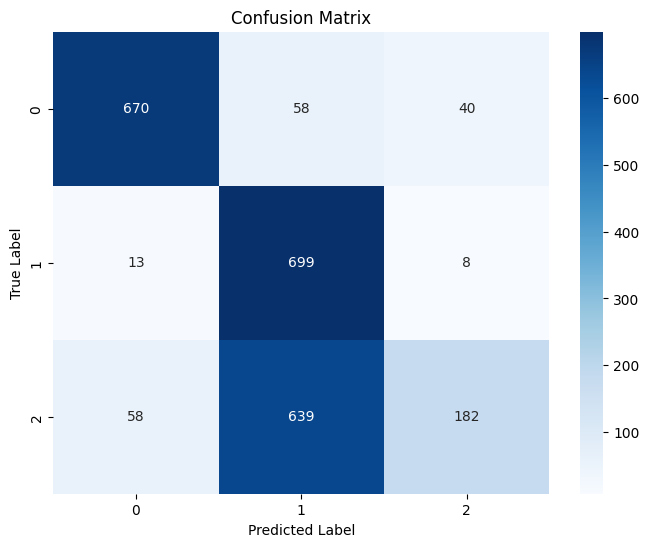

In [34]:
# Create the testing confusion matrix
cm = confusion_matrix(test_results['expected_label'], test_results['predicted_label'])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [35]:
report_dict = classification_report(test_results['expected_label'], test_results['predicted_label'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose() 
report_df.columns.name = 'label'
report_df

label,precision,recall,f1-score,support
CONTRADICTION,0.904184,0.872396,0.888005,768.00000
ENTAILMENT,0.500716,0.970833,0.660681,720.00000
NEUTRAL,0.791304,0.207053,0.328224,879.00000
accuracy,0.655260,0.655260,0.655260,0.65526
macro avg,0.732068,0.683428,0.625636,2367.00000
weighted avg,0.739537,0.655260,0.610979,2367.00000


In [36]:
def compute_metrics_by_type(group):
    predictions = group['expected_label']
    labels = group['predicted_label']
    acc = np.mean(predictions == labels)
    precision = precision_score(labels, predictions,average="weighted")
    recall = recall_score(labels, predictions,average="weighted")
    f1 = f1_score(labels, predictions,average="weighted")
    return pd.Series({'accuracy': round(acc,2), 'precision': round(precision,2), 'recall': round(recall,2), 'f1_score': round(f1,2)})

In [37]:
metrics_by_type = test_results.groupby('type').apply(compute_metrics_by_type).reset_index()
metrics_by_type.columns.name = 'ID'
metrics_by_type

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

ID,type,accuracy,precision,recall,f1_score
0,type1_again,0.41,0.46,0.41,0.42
1,type1_possessive,0.63,0.48,0.63,0.54
2,type2_again,0.50,0.45,0.50,0.44
3,type2_possessive,0.49,0.41,0.49,0.42
4,type3_again,0.53,0.64,0.53,0.52
5,type3_possessive,0.37,0.23,0.37,0.28
6,type4_possessive,0.62,0.88,0.62,0.68
7,type5_again,0.94,0.97,0.94,0.94
8,type5_possessive,0.91,0.93,0.91,0.91


## FacebookAI/roberta-large-mnli

In [32]:
checkpoint = "FacebookAI/roberta-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
tokenized_train_ds = train_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
tokenized_val_ds = val_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
tokenized_test_ds = test_ds.map(lambda x: preprocess_function(x, tokenizer), batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/6486 [00:00<?, ? examples/s]

Map:   0%|          | 0/2348 [00:00<?, ? examples/s]

Map:   0%|          | 0/2367 [00:00<?, ? examples/s]

### Inferencing

In [40]:
from transformers import pipeline
from datasets import load_dataset, Dataset
from transformers.pipelines.pt_utils import KeyDataset, KeyPairDataset
import torch

In [43]:
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU")
    device = torch.device("cpu")

GPU is available!


In [33]:
# labels = ["entailment","neutral","contradiction"]
gen = pipeline('text-classification', model=model, tokenizer=tokenizer, device=device)

Device set to use cuda


In [34]:
id_num = 0
test_results = pd.DataFrame(columns = ['id', 'premise', 'hypothesis', 'type', 'expected_label', 'predicted_label'])

for predicted in gen(KeyPairDataset(test_ds,'premise', 'hypothesis'), batch_size=8, truncation=True):
    if id_num % 100 == 0:
        print(id_num)
    test_results.loc[id_num] = [str(id_num), test_ds['premise'][id_num], test_ds['hypothesis'][id_num], test_ds['type'][id_num], test_ds['label'][id_num], predicted['label']]
    id_num += 1

len(test_results)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


2367

In [35]:
test_results

,id,premise,hypothesis,type,expected_label,predicted_label
0,0,"If Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,ENTAILMENT
1,1,"It's not the case that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,ENTAILMENT
2,2,"Sam believes that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,ENTAILMENT
3,3,"Is it true that if Charlotte passes her driving test, her parents will buy her a car?",Charlotte has parents.,type5_possessive,ENTAILMENT,ENTAILMENT
4,4,"If Lily takes the train to the city, her friend will meet her at the station.",Lily has a friend.,type5_possessive,ENTAILMENT,ENTAILMENT
...,...,...,...,...,...,...
2362,2362,"If Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,ENTAILMENT
2363,2363,"It's not the case that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,ENTAILMENT
2364,2364,"Sam believes that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,ENTAILMENT
2365,2365,"Is it true that if Sophia decides to attend the concert, his best friend will drive him there?",Sophia has a close friend.,type5_possessive,NEUTRAL,ENTAILMENT


In [44]:
test_results['predicted_label']

0          ENTAILMENT
1          ENTAILMENT
2          ENTAILMENT
3          ENTAILMENT
4          ENTAILMENT
            ...      
2362       ENTAILMENT
2363       ENTAILMENT
2364       ENTAILMENT
2365       ENTAILMENT
2366    CONTRADICTION
Name: predicted_label, Length: 2367, dtype: object

In [45]:
test_results['predicted_label'] = test_results['predicted_label'].apply(lambda x: x.upper())
test_results

,id,premise,hypothesis,type,expected_label,predicted_label
0,0,"If Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,ENTAILMENT
1,1,"It's not the case that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,ENTAILMENT
2,2,"Sam believes that if Charlotte passes her driving test, her parents will buy her a car.",Charlotte has parents.,type5_possessive,ENTAILMENT,ENTAILMENT
3,3,"Is it true that if Charlotte passes her driving test, her parents will buy her a car?",Charlotte has parents.,type5_possessive,ENTAILMENT,ENTAILMENT
4,4,"If Lily takes the train to the city, her friend will meet her at the station.",Lily has a friend.,type5_possessive,ENTAILMENT,ENTAILMENT
...,...,...,...,...,...,...
2362,2362,"If Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,ENTAILMENT
2363,2363,"It's not the case that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,ENTAILMENT
2364,2364,"Sam believes that if Sophia decides to attend the concert, his best friend will drive him there.",Sophia has a close friend.,type5_possessive,NEUTRAL,ENTAILMENT
2365,2365,"Is it true that if Sophia decides to attend the concert, his best friend will drive him there?",Sophia has a close friend.,type5_possessive,NEUTRAL,ENTAILMENT


In [36]:
test_results.to_csv('roberta_exp2_test_results.csv')

In [47]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

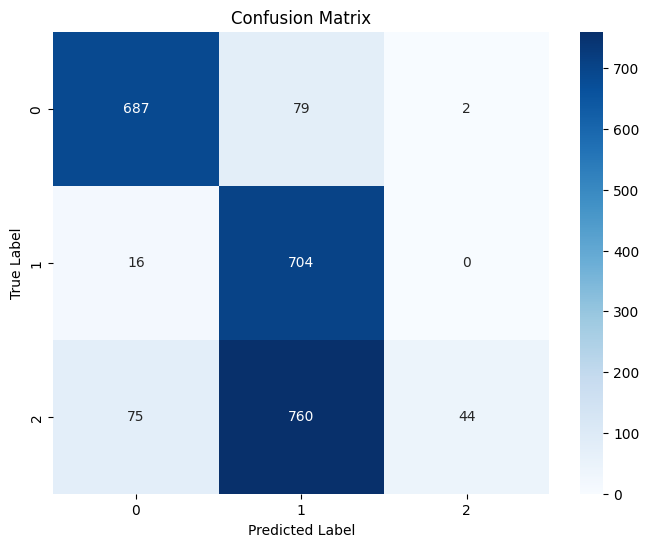

In [48]:
# Create the testing confusion matrix
cm = confusion_matrix(test_results['expected_label'], test_results['predicted_label'])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [49]:
report_dict = classification_report(test_results['expected_label'], test_results['predicted_label'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose() 
report_df.columns.name = 'label'
report_df

label,precision,recall,f1-score,support
CONTRADICTION,0.883033,0.894531,0.888745,768.000000
ENTAILMENT,0.456254,0.977778,0.622183,720.000000
NEUTRAL,0.956522,0.050057,0.095135,879.000000
accuracy,0.606253,0.606253,0.606253,0.606253
macro avg,0.765270,0.640789,0.535354,2367.000000
weighted avg,0.780505,0.606253,0.512950,2367.000000


In [50]:
metrics_by_type = test_results.groupby('type').apply(compute_metrics_by_type).reset_index()
metrics_by_type.columns.name = 'ID'
metrics_by_type

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precis

ID,type,accuracy,precision,recall,f1_score
0,type1_again,0.39,0.45,0.39,0.41
1,type1_possessive,0.48,0.42,0.48,0.42
2,type2_again,0.39,0.43,0.39,0.41
3,type2_possessive,0.42,0.44,0.42,0.42
4,type3_again,0.40,0.56,0.40,0.46
5,type3_possessive,0.41,0.40,0.41,0.40
6,type4_possessive,0.62,1.00,0.62,0.73
7,type5_again,0.97,0.99,0.97,0.98
8,type5_possessive,0.84,0.91,0.84,0.86
